# Preamble

In [1]:
import numpy as np
import matplotlib.pylab as plt

import pymc as pm
import arviz as az
import aesara.tensor as at
import aesara.tensor.extra_ops as ate

import astropy.cosmology as cosmo
import astropy.units as u
import h5py

# Data Generation
$$
m \sim \pi(m|\vec{\lambda}) = f_1 N(m|\mu_1, \sigma_1) + f_2 N(m|\mu_2, \sigma_2) + (1-f_1-f_2) \Bigg(\frac{a(\alpha-1)}{a-\big(\frac{a}{b}\big)^{\alpha}b}\Bigg)\frac{\big(\frac{a}{m}\big)^{\alpha}}{a}
$$

In [2]:
f1 = 0.2
mu1 = 34.0
sigma1 = 3.0
f2 = 0.1
mu2 = 55.0
sigma2 = 1.0
a = 5.0
b = 150.0
alpha = 2.35

In [3]:
class PowerLawPDF(object):
    def __init__(self, alpha, a, b):
        assert alpha > 1

        self.alpha = alpha
        self.a = a
        self.b = b

        self.norm = (self.a - (self.a/self.b)**self.alpha*self.b)/(self.a*(self.alpha-1))

    def __call__(self, x):
        return (self.a/x)**self.alpha/self.a/self.norm
    
    def icdf(self, c):
        return ((self.a**self.alpha*self.b*c + self.a*self.b**self.alpha*(1-c))/(self.a*self.b)**self.alpha)**(1/(1-self.alpha))

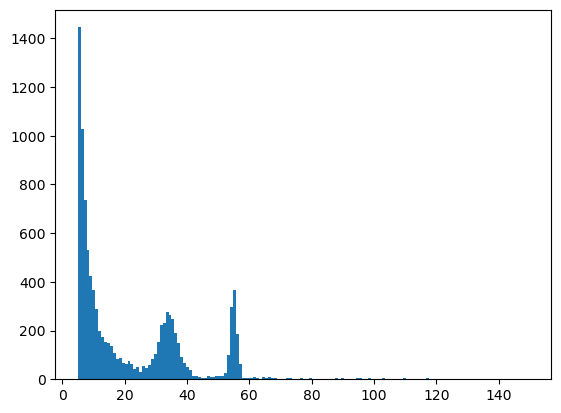

In [4]:
rng = np.random.default_rng(333165393797366967556667466879860422123)

Nobs = 10000

m1 = rng.normal(mu1, sigma1, int(Nobs*f1))
m2 = rng.normal(mu2, sigma2, int(Nobs*f2))
mpowerlaw = PowerLawPDF(alpha,a,b).icdf(rng.uniform(low=0, high=1, size=int(Nobs*(1-f1-f2))))
m = np.concatenate((m1, m2, mpowerlaw))
np.random.shuffle(m)
_ = plt.hist(m, bins=154)

# Inference With Truth

In [5]:
def at_powerlaw_pdf(m, alpha, a=5.0, b=150.0):
    norm = (a - (a/b)**alpha*b)/(a*(alpha-1))
    return (a/m)**alpha/a/norm

In [6]:
def make_model(m):
    
    with pm.Model() as model:
        
        f1 = pm.Uniform('f1', 0.01, 0.9)
        mu1 = pm.Uniform('mu1', 30.0, 40.0)
        sigma1 = pm.Uniform('sigma1', 1.0, 6.0)
        f2 = pm.Uniform('f2', 0.01, 0.9)
        mu2 = pm.Uniform('mu2', 50.0, 60.0)
        sigma2 = pm.Uniform('sigma2', 0.1, 5.0)
        alpha = pm.Uniform('alpha', 1.0, 10.0)

        var = f1*at.exp(pm.logp(pm.Normal.dist(mu1, sigma1), m)) + f2*at.exp(pm.logp(pm.Normal.dist(mu2, sigma2), m)) + (1-f1-f2)*at_powerlaw_pdf(m, alpha)
        pm.Potential('var', at.sum(at.log(var)))
        
    return model

In [7]:
tune = 1000
target_accept = 0.99
with make_model(m) as model:
    trace = pm.sample(tune=tune, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f1, mu1, sigma1, f2, mu2, sigma2, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 162 seconds.


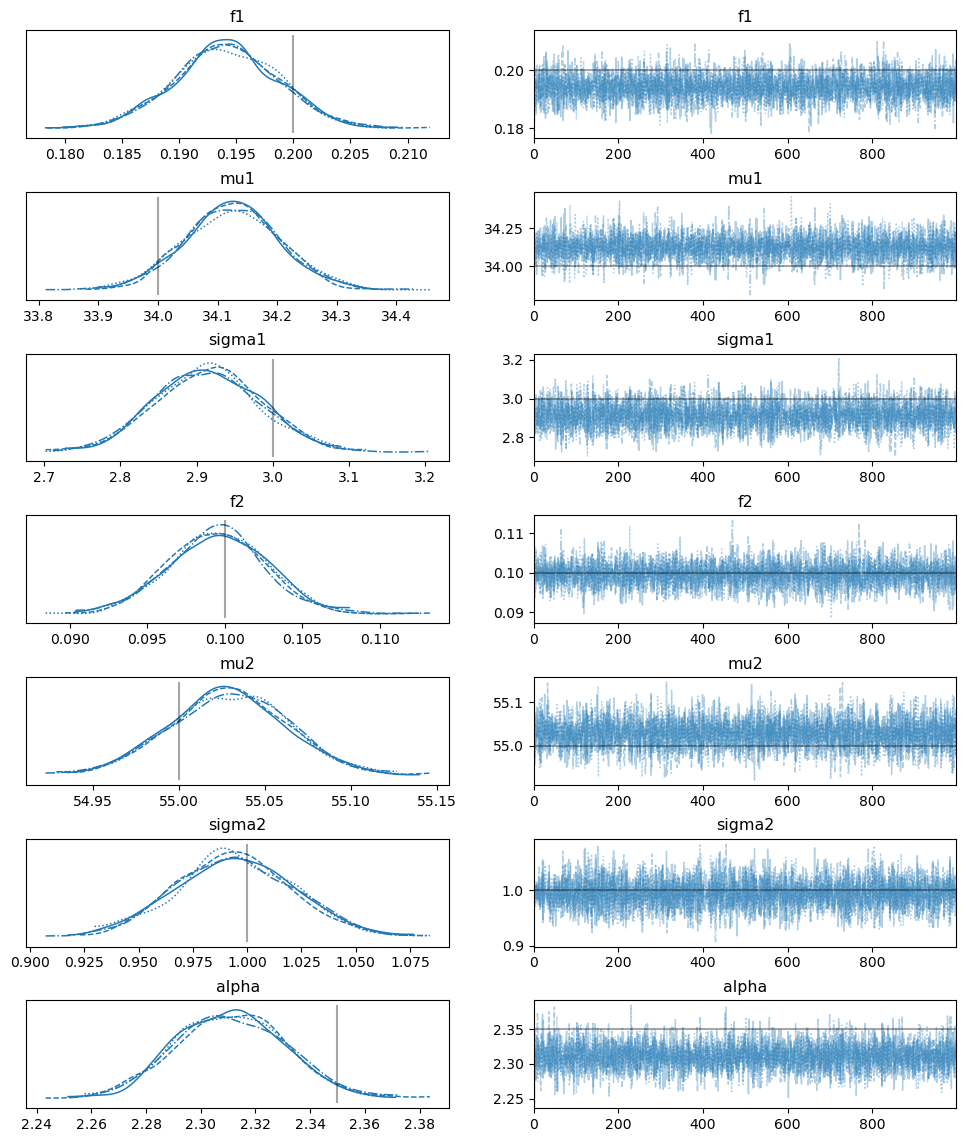

In [8]:
with model:
    axes = az.plot_trace(trace, compact=True, var_names=['f1', 'mu1', 'sigma1', 'f2', 'mu2', 'sigma2', 'alpha'],
                        lines=[('f1', {}, 0.2),
                        ('mu1', {}, 34.0),
                        ('sigma1', {}, 3.0),
                        ('f2', {}, 0.1),
                        ('mu2', {}, 55.0),
                        ('sigma2', {}, 1.0),
                        ('alpha', {}, 2.35),])
    fig = axes.ravel()[0].figure.subplots_adjust(hspace=0.5)

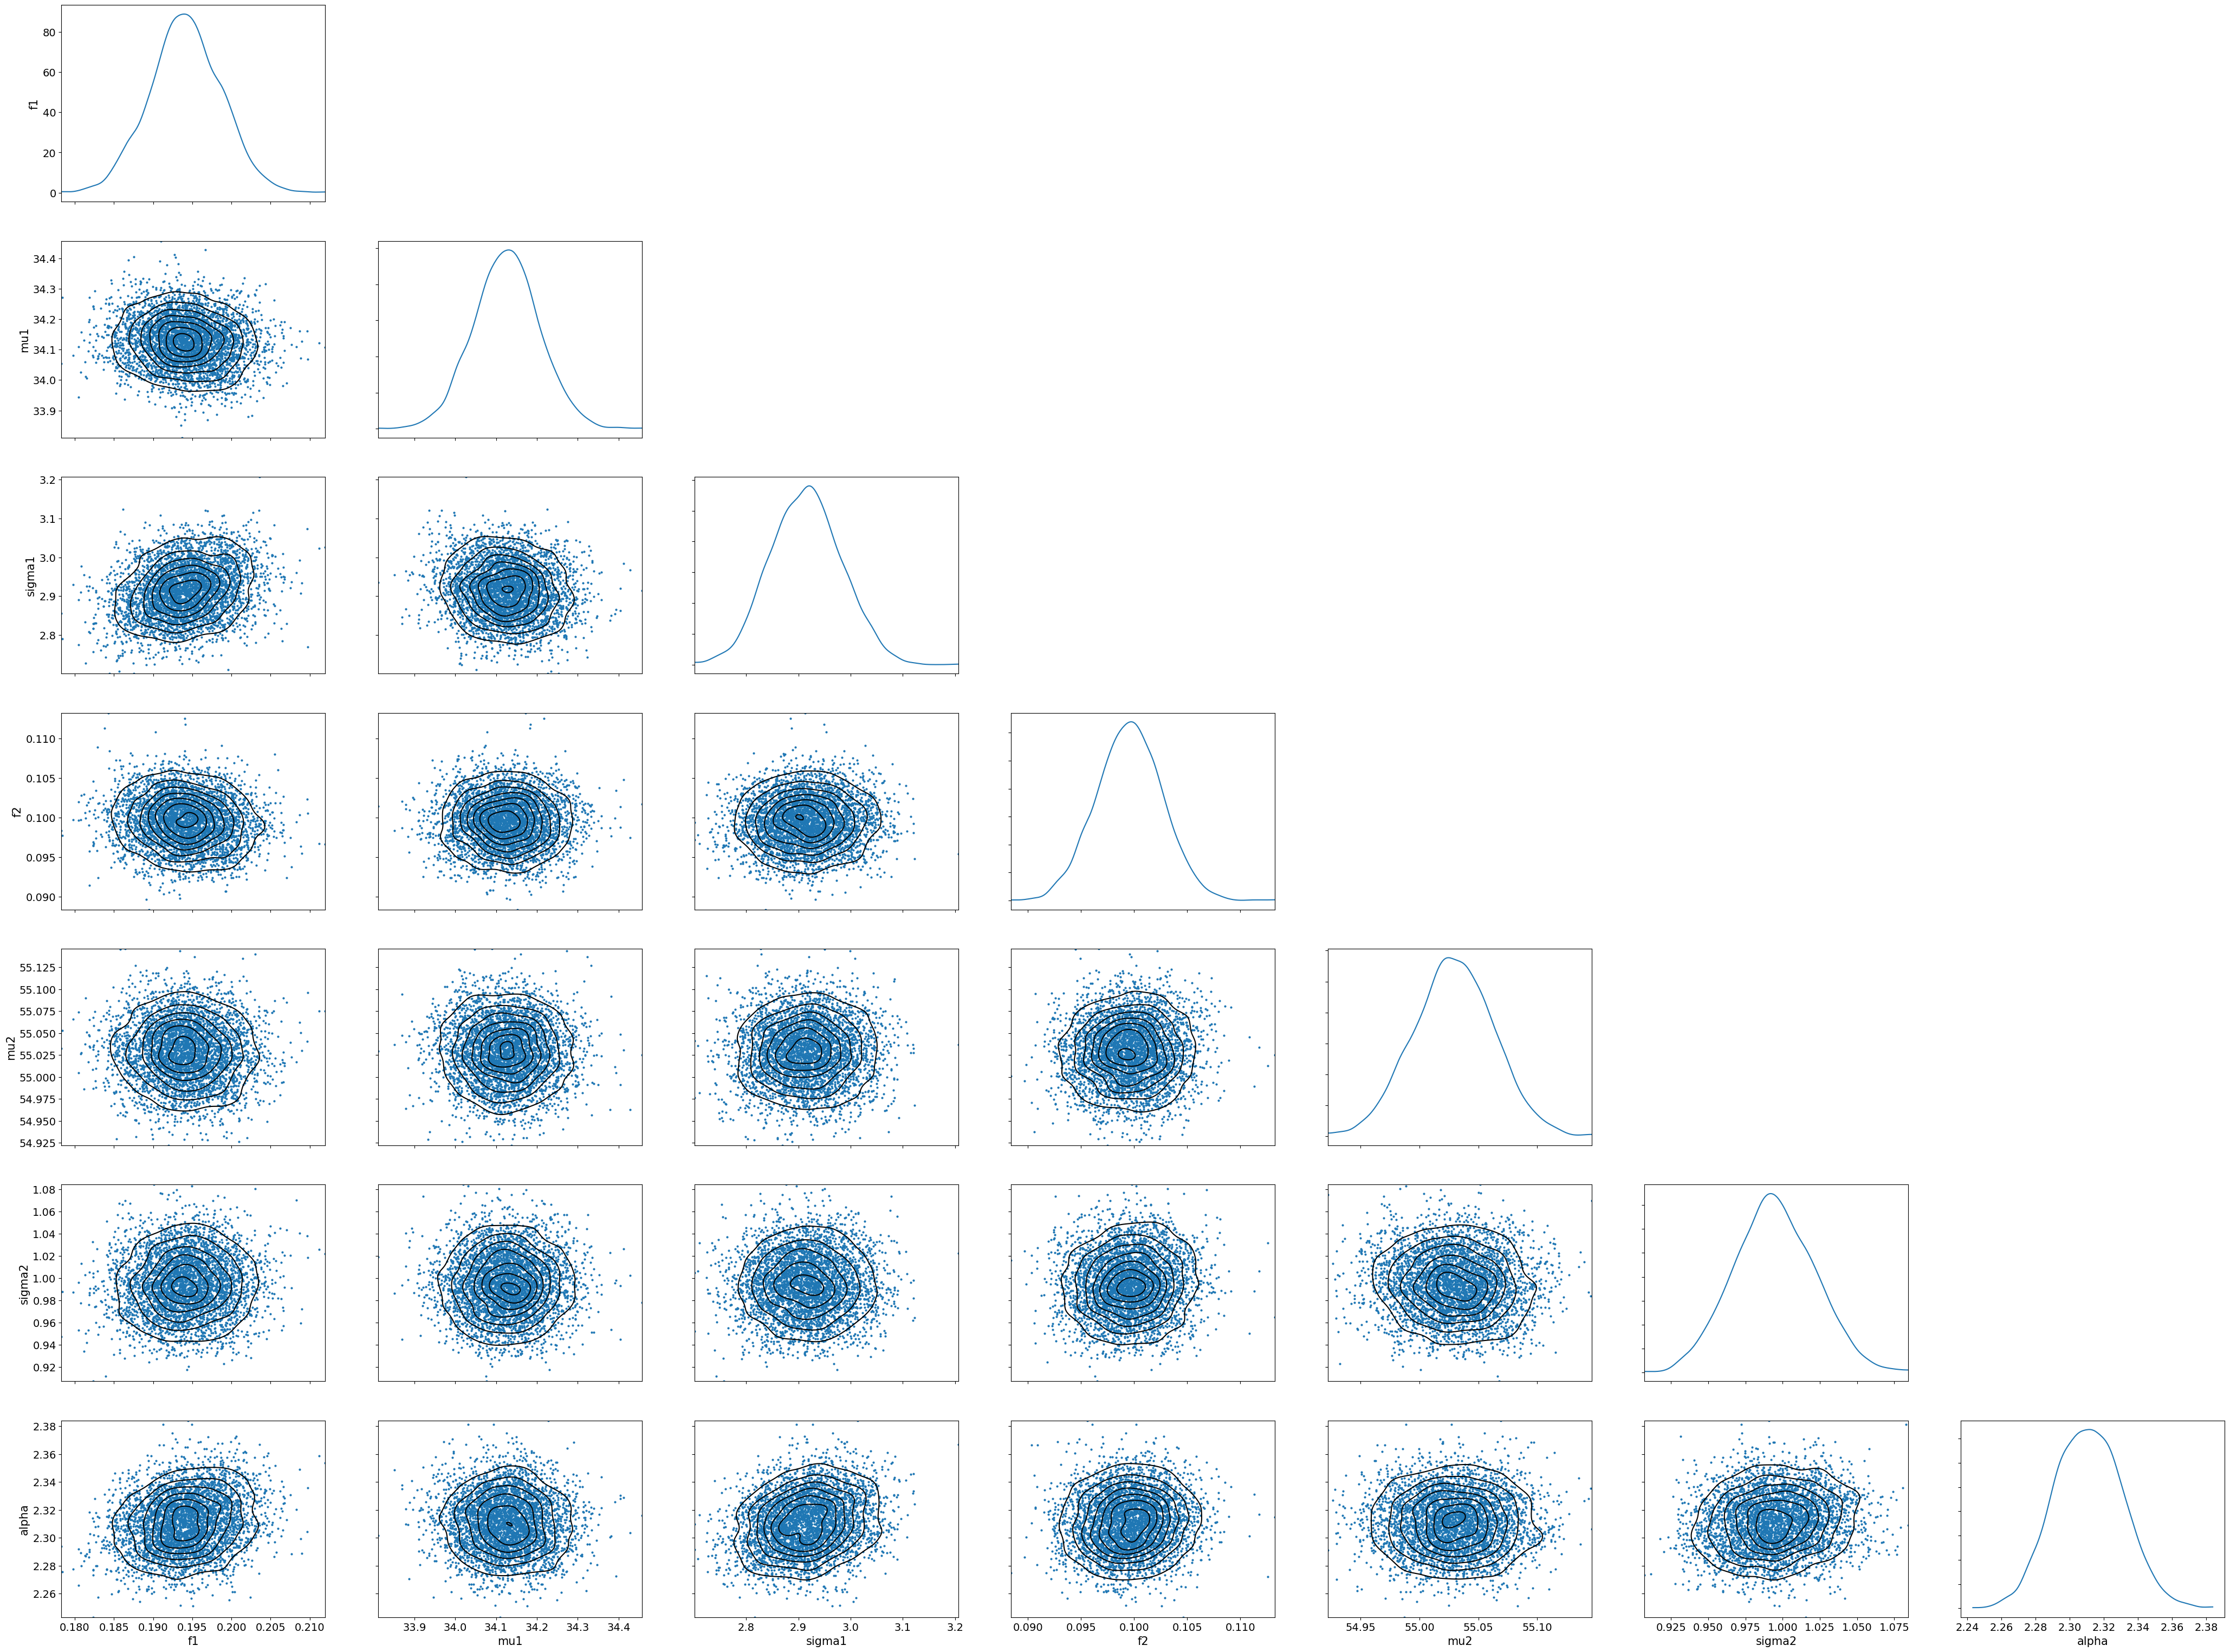

In [9]:
axes1 = az.plot_pair(trace, var_names=['f1', 'mu1', 'sigma1', 'f2', 'mu2', 'sigma2', 'alpha'], marginals=True, kind=['scatter', 'kde'], divergences=True)
fig = axes1.ravel()[0].figure

# Introduce Cut to the Truth

$$
\pi (m|\vec{\lambda}) = N(m|\mu_2,\sigma_2) + \Big(\frac{1-f_1-f_2}{f_2} \Big) \text{PowerLaw}(m|\alpha,a,b)
$$

In [10]:
f1 = 0.2
f2 = 0.1
alpha = 2.35

In [11]:
def make_model1(m):
    
    with pm.Model() as model:

        mu2 = pm.Uniform('mu2', 47.0, 70.0)
        sigma2 = pm.Uniform('sigma2', 0.1, 7.0)
        #fp = pm.Uniform('fp', 0.01, 10.0)
        #alpha = pm.Uniform('alpha', 1.0, 10.0)

        var = f2*at.exp(pm.logp(pm.Normal.dist(mu2, sigma2), m)) + (1-f1-f2)*at_powerlaw_pdf(m, alpha)
        pm.Potential('var', at.sum(at.log(var)))
        
    return model

In [12]:
tune = 1000
target_accept = 0.99
with make_model1(m[m>50.0]) as model:
    trace = pm.sample(tune=tune, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu2, sigma2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


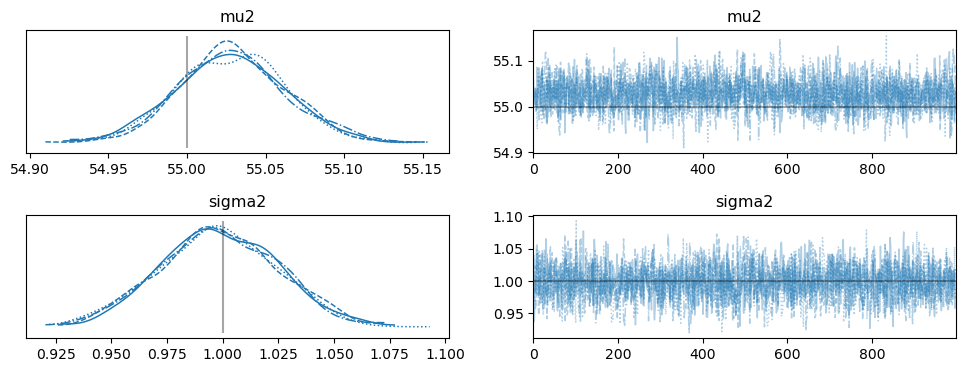

In [13]:
with model:
    axes = az.plot_trace(trace, compact=True, var_names=['mu2', 'sigma2'],
                        lines=[('mu2', {}, 55.0),
                        ('sigma2', {}, 1.0),])
    fig = axes.ravel()[0].figure.subplots_adjust(hspace=0.5)

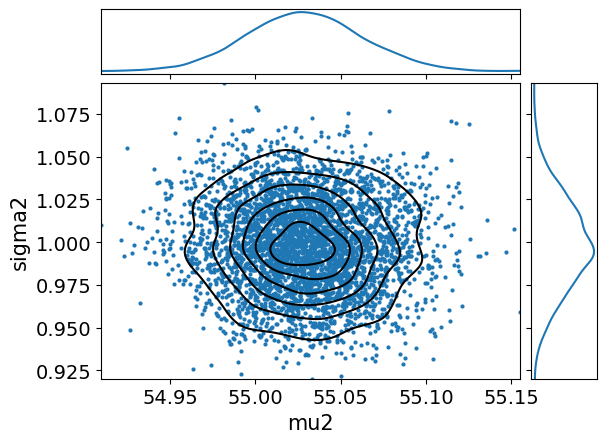

In [14]:
axes1 = az.plot_pair(trace, var_names=['mu2', 'sigma2'], marginals=True, kind=['scatter', 'kde'], divergences=True)
fig = axes1.ravel()[0].figure

# Errorbar

$$
P(m_{obs}|m) = N(m_{obs}|m, sigma)
$$

In [15]:
from scipy.stats import truncnorm

sigma_pe = 1.0

mobs = truncnorm.rvs(a=(5.0-m)/1.0, b=(150.0-m)/1.0, loc=m, scale=sigma_pe)
mobs.shape

(10000,)

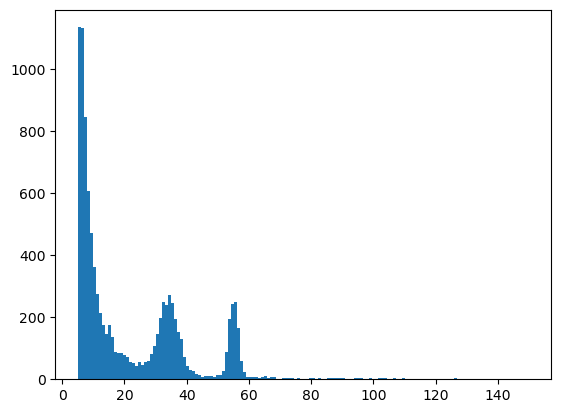

In [16]:
_ = plt.hist(mobs, bins=150)

In [17]:
min(mobs)

5.000293552618149

In [18]:
with h5py.File("mass_data_PLPTP.h5", "w") as file:
    file.create_dataset('mobs', data=mobs)
file.close()

# Inference with the Errorbars

$$
P(\vec{\lambda}|m_{obs}) \propto \pi(\vec{\lambda}) \prod_{obs} \int_m dm \mathcal{L}(m_{obs}|m) \pi(m|\vec{\lambda})
$$

$$
= \pi(\vec{\lambda}) \prod_{obs} \int_m dm \mathcal{N}(m_{obs}|m, \sigma) (f_1\mathcal{N}(m|\mu_1, \sigma_1) + f_2\mathcal{N}(m|\mu_2, \sigma_2) + (1-f_1-f_2)\text{PowerLaw}(m|\alpha))
$$

$$
= \pi(\vec{\lambda}) \prod_{obs} (f_1\mathcal{N}(m_{obs}|\mu_1, \sqrt{\sigma^2+\sigma_1^2}) + f_2\mathcal{N}(m_{obs}|\mu_2, \sqrt{\sigma^2+\sigma_2^2}) + (1-f_1-f_2)\int_{m_{min}}^{m_{max}} dm \mathcal{N}(m_{obs}|m, \sigma) \text{PowerLaw}(m|\alpha))
$$

See 'intensity.py -> pop_model_full_model_with_errorbar' for the model and 'result.ipynb' for the result.

# Modelling Higher Mass Peak with Errorbar

$$
P(\vec{\lambda}|m_{obs}) \propto \pi(\vec{\lambda}) \prod_{obs} (f_2\mathcal{N}(m_{obs}|\mu_2, \sqrt{\sigma^2+\sigma_2^2}) + (1-f_1-f_2)\int_{m_{min}}^{m_{max}} dm \mathcal{N}(m_{obs}|m, \sigma) \text{PowerLaw}(m|\alpha))
$$

See 'intensity.py -> pop_model_higher_mass_with_errorbar' for the model and 'result.ipynb' for the result.